<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-05-29 04:57:37--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-05-29 04:57:37 (153 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



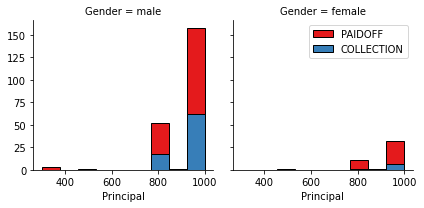

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

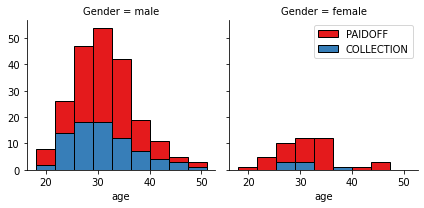

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


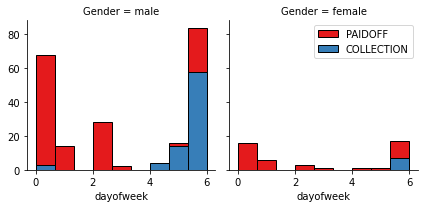

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
X.shape,y.shape,X_train.shape,y_train.shape, y_train[0:5],X_test.shape,y_test.shape

((346, 8),
 (346,),
 (276, 8),
 (276,),
 array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
       dtype=object),
 (70, 8),
 (70,))

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
print()
# Find best KNN
Ks = 11
print("Model Test Set for", Ks-1, "each, k evaluation points:")

mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
j_acc = np.zeros((Ks-1))
f1_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and pred  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_pred=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
    std_acc[n-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])    
    j_acc[n-1]= jaccard_score(y_test, y_pred, pos_label='PAIDOFF')
    f1_acc[n-1] = f1_score(y_test, y_pred, average='weighted')
    print("\t k", n, "Jaccard=", j_acc[n-1], "\t F1=", f1_acc[n-1])

best_a = mean_acc.argmax()+1
best_j = j_acc.argmax()+1
best_f1 = f1_acc.argmax()+1
print()


Model Test Set for 10 each, k evaluation points:
	 k 1 Jaccard= 0.6031746031746031 	 F1= 0.6681536285496682
	 k 2 Jaccard= 0.5245901639344263 	 F1= 0.6227734745236461
	 k 3 Jaccard= 0.7142857142857143 	 F1= 0.7485119047619048
	 k 4 Jaccard= 0.6557377049180327 	 F1= 0.7212490479817212
	 k 5 Jaccard= 0.71875 	 F1= 0.7428571428571429
	 k 6 Jaccard= 0.6774193548387096 	 F1= 0.7298534798534798
	 k 7 Jaccard= 0.7741935483870968 	 F1= 0.8
	 k 8 Jaccard= 0.7213114754098361 	 F1= 0.7687074829931972
	 k 9 Jaccard= 0.7313432835820896 	 F1= 0.7173645320197043
	 k 10 Jaccard= 0.6451612903225806 	 F1= 0.7064720625092141




Best KNN = 7 , Jaccard = 0.7213114754098361


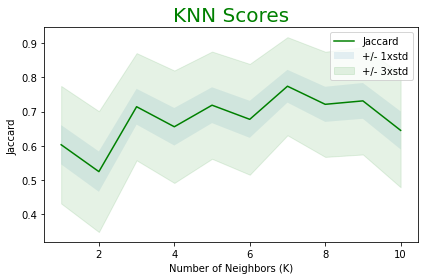

In [22]:
print()
print("Best KNN =",best_j,", Jaccard =", j_acc[best_j])
plt.plot(range(1,Ks),j_acc,'g')
plt.fill_between(range(1,Ks),j_acc - 1 * std_acc,j_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),j_acc - 3 * std_acc,j_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Jaccard ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Jaccard ')
plt.xlabel('Number of Neighbors (K)')
plt.title(label="KNN Scores",fontsize=20,color="green")
plt.tight_layout()
plt.show()


Best KNN = 7 , F-1 Score = 0.7687074829931972


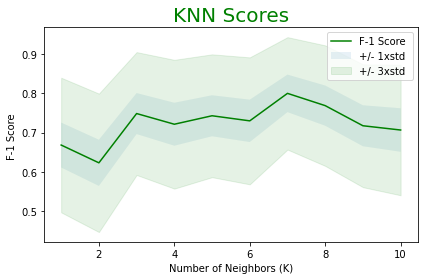

In [23]:
print()
print("Best KNN =",best_f1,", F-1 Score =", f1_acc[best_f1])
plt.plot(range(1,Ks),f1_acc,'g')
plt.fill_between(range(1,Ks),f1_acc - 1 * std_acc,f1_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),f1_acc - 3 * std_acc,f1_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('F-1 Score ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('F-1 Score ')
plt.xlabel('Number of Neighbors (K)')
plt.title(label="KNN Scores",fontsize=20,color="green")
plt.tight_layout()
plt.show()

In [24]:
print()
neigh = KNeighborsClassifier(n_neighbors = best_j).fit(X_train,y_train)
print("KNN Model Evaluation Metrics, best k:")
print("\t Train Set Jaccard Score where best k=", best_j,"is", jaccard_score(y_train, neigh.predict(X_train), pos_label='PAIDOFF'))
print("\t Test Set Jaccard Score where best k=", best_j,"is", j_acc[best_j-1])
print()
neigh = KNeighborsClassifier(n_neighbors = best_f1).fit(X_train,y_train)
print("\t Model Train set F1 Score where best k=",best_f1,"is",f1_score(y_train, neigh.predict(X_train), average='weighted'))
print("\t Model Test Set F1 Score where best k =",best_f1,"is", f1_acc[best_f1-1])
KNN_jacc=best_j
KNN_f1=best_f1


KNN Model Evaluation Metrics, best k:
	 Train Set Jaccard Score where best k= 7 is 0.7759336099585062
	 Test Set Jaccard Score where best k= 7 is 0.7741935483870968

	 Model Train set F1 Score where best k= 7 is 0.7942614463042823
	 Model Test Set F1 Score where best k = 7 is 0.8


# Decision Tree


In [25]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree


In [26]:
# Find best Decision Tree Depth
print()
Ds = 11
print("Test set using", Ds-1, "max depth points for evaluation:")

j_acc = np.zeros((Ds-1))
f1_acc = np.zeros((Ds-1))
for d in range(1,Ds):
    
    #Train Model and pred  

    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = d).fit(X_train,y_train)
    predTree = loanTree.predict(X_test)
    j_acc[d-1]= jaccard_score(y_test, predTree, pos_label='PAIDOFF')
    f1_acc[d-1] = f1_score(y_test, predTree, average='weighted')
    print("\t k", d, "Jaccard=", j_acc[d-1], "\t F1=", f1_acc[d-1])

best_j = j_acc.argmax()+1
best_f1 = f1_acc.argmax()+1


Test set using 10 max depth points for evaluation:
	 k 1 Jaccard= 0.7857142857142857 	 F1= 0.6914285714285714
	 k 2 Jaccard= 0.7857142857142857 	 F1= 0.6914285714285714
	 k 3 Jaccard= 0.5714285714285714 	 F1= 0.6445993031358885
	 k 4 Jaccard= 0.5714285714285714 	 F1= 0.6445993031358885
	 k 5 Jaccard= 0.5833333333333334 	 F1= 0.6741854636591479
	 k 6 Jaccard= 0.7681159420289855 	 F1= 0.7064793130366899
	 k 7 Jaccard= 0.7536231884057971 	 F1= 0.6978810663021189
	 k 8 Jaccard= 0.7536231884057971 	 F1= 0.6978810663021189
	 k 9 Jaccard= 0.625 	 F1= 0.6758241758241758
	 k 10 Jaccard= 0.6911764705882353 	 F1= 0.6765217391304347


Decision Tree, max_depth = 2


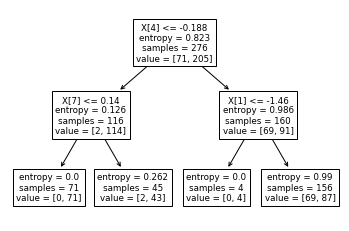

In [27]:
print("Decision Tree, max_depth =", best_j+1)
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = best_j+1).fit(X_train,y_train)
tree.plot_tree(loanTree)
plt.show()

Decision Tree, max_depth = 6


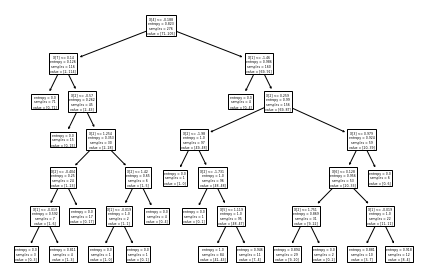

In [28]:
print("Decision Tree, max_depth =", best_f1 )
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = best_f1).fit(X_train,y_train)
tree.plot_tree(loanTree)
plt.tight_layout()
plt.show()

In [29]:
print()
print("Decision Tree Model Evaluation, best d:")
print()
print("\t Train Set Jaccard Score =", jaccard_score(y_train, loanTree.predict(X_train), pos_label='PAIDOFF'))
print("\t Test  Set Jaccard Score =", j_acc[best_j-1])
print()
print("\t Train Set F1 Score =",f1_score(y_train, loanTree.predict(X_train), pos_label='PAIDOFF'))
print("\t Test  Set F1 Score =", f1_acc[best_f1-1])
DPTH_jacc= 2
DPTH_f1 = best_f1
print()


Decision Tree Model Evaluation, best d:

	 Train Set Jaccard Score = 0.7606177606177607
	 Test  Set Jaccard Score = 0.7857142857142857

	 Train Set F1 Score = 0.8640350877192982
	 Test  Set F1 Score = 0.7064793130366899



# Support Vector Machine


In [30]:
from sklearn import svm

In [31]:
d=0
print("Test Kernels - linear, poly, rbf and sigmoid functions:")
print()
j_acc = np.zeros((Ds-1))
f1_acc = np.zeros((Ds-1))
krnl = ['linear', 'poly', 'rbf','sigmoid']
for kfn in ['linear', 'poly', 'rbf','sigmoid']:
    d=d+1
    clf_model = svm.SVC(kernel = kfn).fit(X_train,y_train)
    svm_yhat = clf_model.predict(X_test)  
    j_acc[d-1]= jaccard_score(y_test, svm_yhat, pos_label='PAIDOFF')
    f1_acc[d-1] = f1_score(y_test, svm_yhat, average='weighted')
    print("\t Model as", kfn, "Jaccard =", j_acc[d-1], "\t F1 =", f1_acc[d-1])
    
best_j = j_acc.argmax()+1
best_f1 = f1_acc.argmax()+1
print()

Test Kernels - linear, poly, rbf and sigmoid functions:

	 Model as linear Jaccard = 0.7857142857142857 	 F1 = 0.6914285714285714
	 Model as poly Jaccard = 0.7681159420289855 	 F1 = 0.7064793130366899
	 Model as rbf Jaccard = 0.7272727272727273 	 F1 = 0.7275882012724117
	 Model as sigmoid Jaccard = 0.7391304347826086 	 F1 = 0.6892857142857144



In [32]:
print()
print("Reporting SVM Model Evaluation Metrics, Best Kernel:")
print()
clf_model = svm.SVC( kernel = krnl[best_j-1]).fit(X_train,y_train)
SVM_j= krnl[best_j]
print('SVM kernel for Jaccard =',SVM_j)
print("\t Train Set Jaccard Score kernel =", best_j,"is" , jaccard_score(y_train, clf_model.predict(X_train), pos_label='PAIDOFF'))
print("\t Test  Set Jaccard Score kernel =", best_j,"is" , j_acc[best_j-1])
print()
clf_model = svm.SVC( kernel = krnl[best_f1-1]).fit(X_train,y_train)
SVM_f1=krnl[best_f1]
print("SVM kernel for F1-Score = ",SVM_f1)
print("\t Train Set F1 Score kernel =", best_f1,"is" ,f1_score(y_train, clf_model.predict(X_train),pos_label='PAIDOFF'))
print("\t Test  Set F1 Score kernel =", best_f1,"is" , f1_acc[best_f1-1])
print()


Reporting SVM Model Evaluation Metrics, Best Kernel:

SVM kernel for Jaccard = poly
	 Train Set Jaccard Score kernel = 1 is 0.7427536231884058
	 Test  Set Jaccard Score kernel = 1 is 0.7857142857142857

SVM kernel for F1-Score =  sigmoid
	 Train Set F1 Score kernel = 3 is 0.8611111111111112
	 Test  Set F1 Score kernel = 3 is 0.7275882012724117



# Logistic Regression


In [33]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss 

In [34]:
d=0
print()
print("Test model using 'lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag' functions:")
print()
ll_acc = np.zeros((6))
krnl= ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']
for k in ('lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag') :  
    LR = LogisticRegression(C = 0.01, solver = k).fit(X_train, y_train)
    lr_yhat = LR.predict(X_test)
    y_prob = LR.predict_proba(X_test)
    ll_acc[d] = log_loss(y_test, y_prob)
    print("\t LogLoss", k, "=", log_loss(y_test,y_prob))
    d=d+1
    best_ll=ll_acc.argmin()
print(krnl[best_ll-1],best_ll)


Test model using 'lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag' functions:

	 LogLoss lbfgs = 0.4920179847937498
	 LogLoss saga = 0.49201805240601765
	 LogLoss liblinear = 0.5772287609479654
	 LogLoss newton-cg = 0.492017801467927
	 LogLoss sag = 0.4920230357786365
sag 5


In [35]:
# print ("Using 'linlinear' for the Logistics Regression:")

print()
print("Best Solver with Log Loss min,",krnl[best_ll-1],", with log loss =",ll_acc[best_ll-1])
print()
print("Train set Accuracy (Jaccard): ", jaccard_score(y_train, LR.predict(X_train), pos_label='PAIDOFF'))
print("Test set Accuracy (Jaccard): ",  jaccard_score(y_test, LR.predict(X_test), pos_label='PAIDOFF'))
print("Train set Accuracy (F1): ", f1_score(y_train, LR.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", f1_score(y_test, LR.predict(X_test), average='weighted'))
print()
LR_solver = krnl[best_ll-1]


Best Solver with Log Loss min, sag , with log loss = 0.4920230357786365

Train set Accuracy (Jaccard):  0.7427536231884058
Test set Accuracy (Jaccard):  0.7857142857142857
Train set Accuracy (F1):  0.6331163939859591
Test set Accuracy (F1):  0.6914285714285714



# Model Evaluation using Test set


In [36]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [37]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-05-29 04:57:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-05-29 04:57:55 (62.0 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [38]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [39]:
# Prepare Data
# Convert Dates
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
# Add Binary Info Weekend and Gender
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# Set Feature and expand 'education" drop 'Masters or Above'
Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)
# Standardise Features in x test matrix
X_loan_test = Feature1
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)
print("X loan test shape:", X_loan_test[0:5], X_loan_test.shape)
# Set y test array
y_loan_test = test_df['loan_status'].values
print("y loan test shape", y_loan_test[0:5],y_loan_test.shape)


X loan test shape: [[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]] (54, 8)
y loan test shape ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'] (54,)


In [40]:
print("Model Parameters:")
print("KNN best k, Jaccard =", KNN_jacc)
print("KNN best k, F1 Score =", KNN_f1)
print("Decision Tree best depth, Jaccard =", DPTH_jacc)
print("Decision Tree best depth, F1_Score =", DPTH_f1)
print('SVM kernel function, Jaccard =',SVM_j)
print("SVM kernel function, F1-Score = ",SVM_f1)
print("LR best solver =", LR_solver)

Model Parameters:
KNN best k, Jaccard = 7
KNN best k, F1 Score = 7
Decision Tree best depth, Jaccard = 2
Decision Tree best depth, F1_Score = 6
SVM kernel function, Jaccard = poly
SVM kernel function, F1-Score =  sigmoid
LR best solver = sag


In [41]:
    print()
    #Train Model, Predict &  Evaluate
    neigh = KNeighborsClassifier(n_neighbors = KNN_f1).fit(X_train,y_train)
    y_pred=neigh.predict(X_loan_test) 
    kj_acc = jaccard_score(y_loan_test, y_pred, pos_label='PAIDOFF')
    kf1_acc = f1_score(y_loan_test, y_pred, average='weighted')
    print("\t K-Nearest Neighbor, k =", KNN_f1, ": Jaccard =", kj_acc, ", F1=", kf1_acc)
    
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = DPTH_jacc).fit(X_train,y_train)
    predTree = loanTree.predict(X_loan_test)
    dj_acc= jaccard_score(y_loan_test, predTree, pos_label='PAIDOFF')
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = DPTH_f1).fit(X_train,y_train)
    predTree = loanTree.predict(X_loan_test)   
    df1_acc = f1_score(y_loan_test, predTree, average='weighted')
    print("\t Decision Tree, depth =", DPTH_jacc, ": Jaccard=", dj_acc, ", depth", DPTH_jacc, "F1=", df1_acc)
    
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = DPTH_f1).fit(X_train,y_train)
    predTree = loanTree.predict(X_loan_test)
    ddj_acc= jaccard_score(y_loan_test, predTree, pos_label='PAIDOFF')
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = DPTH_f1).fit(X_train,y_train)
    predTree = loanTree.predict(X_loan_test)   
    ddf1_acc = f1_score(y_loan_test, predTree, average='weighted')
    print("\t Decision Tree, depth =", DPTH_f1, ": Jaccard=", ddj_acc, ", depth", DPTH_f1, "F1=", ddf1_acc)
    
    
    clf_model = svm.SVC(kernel = SVM_j).fit(X_train,y_train)
    svm_yhat = clf_model.predict(X_loan_test)  
    cj_acc = jaccard_score(y_loan_test, svm_yhat, pos_label='PAIDOFF')
    cf1_acc = f1_score(y_loan_test, svm_yhat, average='weighted')
    print("\t Support Vector Machine,", SVM_j, ", Jaccard =", cj_acc,",", SVM_f1, "F1 =", cf1_acc)
    clf_model = svm.SVC(kernel = SVM_f1).fit(X_train,y_train)
    svm_yhat = clf_model.predict(X_loan_test)  
    ccj_acc = jaccard_score(y_loan_test, svm_yhat, pos_label='PAIDOFF')
    ccf1_acc = f1_score(y_loan_test, svm_yhat, average='weighted')
    print("\t Support Vector Machine,", SVM_f1, ", Jaccard =", ccj_acc,",", SVM_f1, "F1 =", ccf1_acc)   
    
    LR = LogisticRegression(C = 0.01, solver = k).fit(X_train, y_train)
    lr_yhat = LR.predict(X_loan_test)
    y_prob = LR.predict_proba(X_loan_test)
    ll_acc = log_loss(y_loan_test, y_prob)
    ll_jcc = jaccard_score(y_loan_test, lr_yhat, pos_label='PAIDOFF')
    ll_f1 = f1_score(y_loan_test,lr_yhat, average='weighted')
    
    print("\t Logistic Regression function,", LR_solver, "Log Loss =", log_loss(y_loan_test,y_prob),": Jaccard =", ll_jcc, ", F1 =", ll_f1)
    print()


	 K-Nearest Neighbor, k = 7 : Jaccard = 0.6666666666666666 , F1= 0.6602254428341383
	 Decision Tree, depth = 2 : Jaccard= 0.7407407407407407 , depth 2 F1= 0.6704776923582364
	 Decision Tree, depth = 6 : Jaccard= 0.7115384615384616 , depth 6 F1= 0.6704776923582364
	 Support Vector Machine, poly , Jaccard = 0.75 , sigmoid F1 = 0.6959228135698723
	 Support Vector Machine, sigmoid , Jaccard = 0.6981132075471698 , sigmoid F1 = 0.6378600823045267
	 Logistic Regression function, sag Log Loss = 0.5163662542376329 : Jaccard = 0.7407407407407407 , F1 = 0.6304176516942475



In [42]:
from tabulate import tabulate
# import module
from tabulate import tabulate

# assign data
mydata = [
	["KNN", kj_acc, kf1_acc,"NA"],
	["Decision Tree", dj_acc, df1_acc,"NA"],
	["SVM", cj_acc , cf1_acc,"NA"],
	["Logistic Regression", ll_jcc, ll_f1,ll_acc]
]

# create header
head = ["Algorithm", "Jaccard", "F1-Score", "LogLoss"]

# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


+---------------------+-----------+------------+--------------------+
| Algorithm           |   Jaccard |   F1-Score | LogLoss            |
+=====================+===========+============+====================+
| KNN                 |  0.666667 |   0.660225 | NA                 |
+---------------------+-----------+------------+--------------------+
| Decision Tree       |  0.740741 |   0.670478 | NA                 |
+---------------------+-----------+------------+--------------------+
| SVM                 |  0.75     |   0.695923 | NA                 |
+---------------------+-----------+------------+--------------------+
| Logistic Regression |  0.740741 |   0.630418 | 0.5163662542376329 |
+---------------------+-----------+------------+--------------------+


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | kj_acc  | kf1      | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


# <h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
